In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv('Data/Alcohol_Sales.csv',index_col=0,parse_dates=True)
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [3]:
df.shape

(325, 1)

In [4]:
df.columns = ['Sales']

In [5]:
df.tail()

,Sales
DATE,
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174
2018-12-01,15504
2019-01-01,10718


In [7]:
# df['Sales'].plot(figsize=(12,5));

In [9]:
# results = seasonal_decompose(df['Sales'],model='additive')
# results.plot();

In [10]:
# results.trend.plot(figsize=(11,4));

In [12]:
# results.seasonal.plot(figsize=(11,4));

In [13]:
# results.resid.plot(figsize=(11,4));

In [14]:
df.index.freq = 'MS'

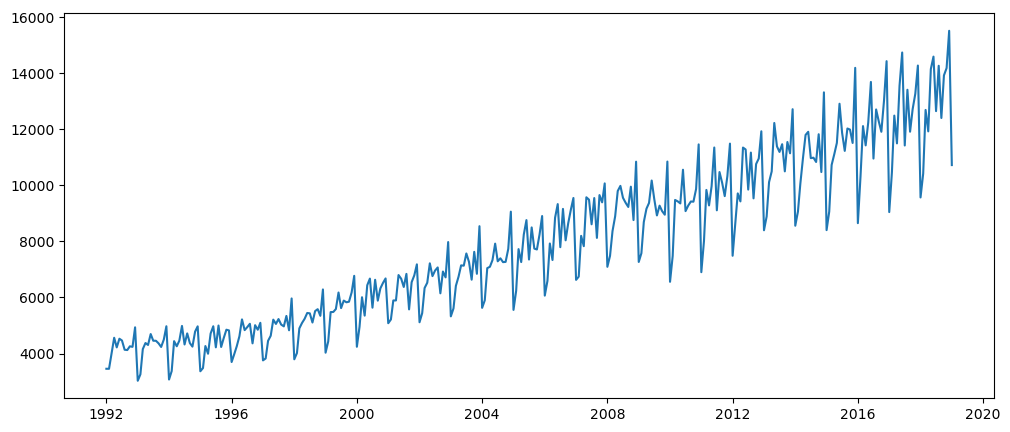

In [42]:
plt.figure(figsize=(12,5))
plt.plot(df['Sales']);

In [15]:
train = df[:313]
test = df[313:]

In [16]:
train.shape, test.shape

((313, 1), (12, 1))

In [17]:
train.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [18]:
test

,Sales
DATE,
2018-02-01,10415
2018-03-01,12683
2018-04-01,11919
2018-05-01,14138
2018-06-01,14583
2018-07-01,12640
2018-08-01,14257
2018-09-01,12396
2018-10-01,13914


In [19]:
# Feature scaling
series = np.array([4,9,23,58,25])
series

array([ 4,  9, 23, 58, 25])

In [20]:
series / series.max() # Simplest form of scaling

array([0.06896552, 0.15517241, 0.39655172, 1.        , 0.43103448])

In [21]:
scaler = MinMaxScaler()
train.Sales = scaler.fit_transform(train[['Sales']]) # Only fit scaling procedure on train data as doing so on test data could result in cheating a little bit by getting a little knowledge about the test set 

In [22]:
train.head()

,Sales
DATE,
1992-01-01,0.036584
1992-02-01,0.036499
1992-03-01,0.082999
1992-04-01,0.131037
1992-05-01,0.101718


In [23]:
test.Sales = scaler.transform(test[['Sales']])
test.head()

,Sales
DATE,
2018-02-01,0.631165
2018-03-01,0.825028
2018-04-01,0.759723
2018-05-01,0.949397
2018-06-01,0.987435


In [25]:
train.iloc[:5]

,Sales
DATE,
1992-01-01,0.036584
1992-02-01,0.036499
1992-03-01,0.082999
1992-04-01,0.131037
1992-05-01,0.101718


In [122]:
n_inputs = 12
n_features = 1

train_generator = TimeseriesGenerator(train.values,train.values,length=n_inputs,batch_size=1)
train_generator

In [123]:
len(train)

313

In [124]:
len(train_generator)

301

In [125]:
X, y = train_generator[4]
X, y

(array([[[0.1017181 ],
         [0.12804513],
         [0.12266006],
         [0.09453799],
         [0.09359774],
         [0.10496624],
         [0.10334217],
         [0.16283443],
         [0.        ],
         [0.0196598 ],
         [0.09650397],
         [0.11505257]]]),
 array([[0.10906915]]))

In [126]:
X.shape, y.shape

((1, 12, 1), (1, 1))

In [127]:
test_generator = TimeseriesGenerator(test.values,test.values,length=4,batch_size=1)
test_generator

In [128]:
model = Sequential()
model.add(LSTM(150,activation='relu',input_shape=(n_inputs,n_features)))
model.add(Dense(1,activation='linear'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 150)               91200     
                                                                 
 dense_4 (Dense)             (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [129]:
model.compile(loss='mse',optimizer='adam')

In [130]:
model.fit_generator(train_generator,epochs=25)

Epoch 1/25
301/301 [==============================] - 3s 5ms/step - loss: 0.0158
Epoch 2/25
301/301 [==============================] - 2s 5ms/step - loss: 0.0095
Epoch 3/25
301/301 [==============================] - 1s 5ms/step - loss: 0.0099
Epoch 4/25
301/301 [==============================] - 2s 7ms/step - loss: 0.0075
Epoch 5/25
301/301 [==============================] - 2s 6ms/step - loss: 0.0063
Epoch 6/25
301/301 [==============================] - 2s 5ms/step - loss: 0.0056
Epoch 7/25
301/301 [==============================] - 2s 5ms/step - loss: 0.0040
Epoch 8/25
301/301 [==============================] - 1s 5ms/step - loss: 0.0032
Epoch 9/25
301/301 [==============================] - 2s 5ms/step - loss: 0.0023
Epoch 10/25
301/301 [==============================] - 2s 6ms/step - loss: 0.0027
Epoch 11/25
301/301 [==============================] - 2s 5ms/step - loss: 0.0023
Epoch 12/25
301/301 [==============================] - 2s 5ms/step - loss: 0.0022
Epoch 13/25
301/301 [====

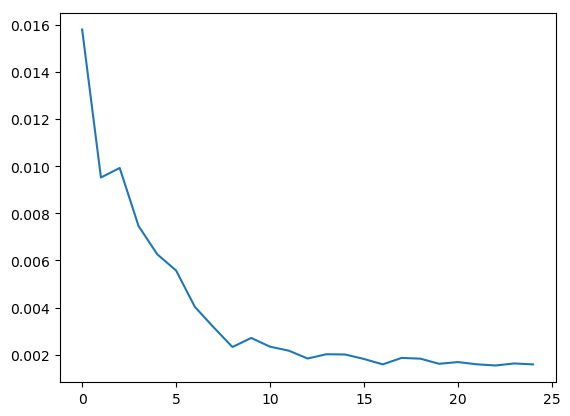

In [131]:
plt.plot(range(25),model.history.history['loss']);

In [132]:
# 12 history steps -> timestep 13
first_eval_batch = train.iloc[-n_inputs:].values
first_eval_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [133]:
first_eval_batch.shape

(12, 1)

In [134]:
first_eval_batch = first_eval_batch.reshape((1,n_inputs,n_features))
first_eval_batch

array([[[0.63432772],
        [0.80776135],
        [0.72313873],
        [0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ]]])

In [135]:
model.predict(first_eval_batch)[0][0]

1/1 [==============================] - 1s 563ms/step


0.69029766

In [137]:
test_predictions = []
first_eval_batch = train[-n_inputs:].values
current_batch = first_eval_batch.reshape((1,n_inputs,n_features))

for i in range(len(test)):
    pred = model.predict(current_batch)[0]
    test_predictions.append(pred)
    current_batch = np.append(current_batch[:,1:,:],[[pred]],axis=1)

1/1 [==============================] - 0s 22ms/step


In [138]:
test.values.shape

(12, 1)

In [139]:
test_predictions = np.array(test_predictions)
test_predictions.shape

(12, 1)

In [140]:
test_predictions

array([[0.69029766],
       [0.8247324 ],
       [0.76681703],
       [0.9273901 ],
       [1.0131452 ],
       [0.75785255],
       [0.90914345],
       [0.7787528 ],
       [0.8511026 ],
       [0.89439094],
       [0.97358227],
       [0.6018433 ]], dtype=float32)

In [141]:
print("MAE:",mean_absolute_error(test.values,test_predictions))
print("MSE:",mean_squared_error(test.values,test_predictions))
print("RMSE:",np.sqrt(mean_squared_error(test.values,test_predictions)))

MAE: 0.04457817946062317
MSE: 0.002749848756455401
RMSE: 0.05243900033806328


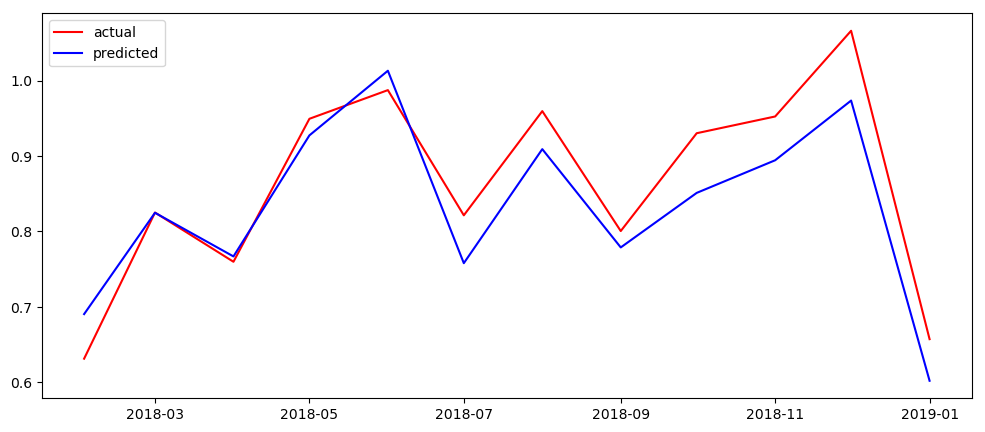

In [142]:
plt.figure(figsize=(12,5))
plt.plot(test,'r',label='actual')
plt.plot(pd.DataFrame(test_predictions,index=test.index,columns=test.columns),'b',label='predicted')
plt.legend()
plt.show();

In [143]:
true_predictions = scaler.inverse_transform(test_predictions.reshape(-1,1))
true_predictions

array([[11106.792 ],
       [12679.545 ],
       [12001.993 ],
       [13880.536 ],
       [14883.785 ],
       [11897.117 ],
       [13667.069 ],
       [12141.629 ],
       [12988.049 ],
       [13494.4795],
       [14420.938 ],
       [10071.965 ]], dtype=float32)

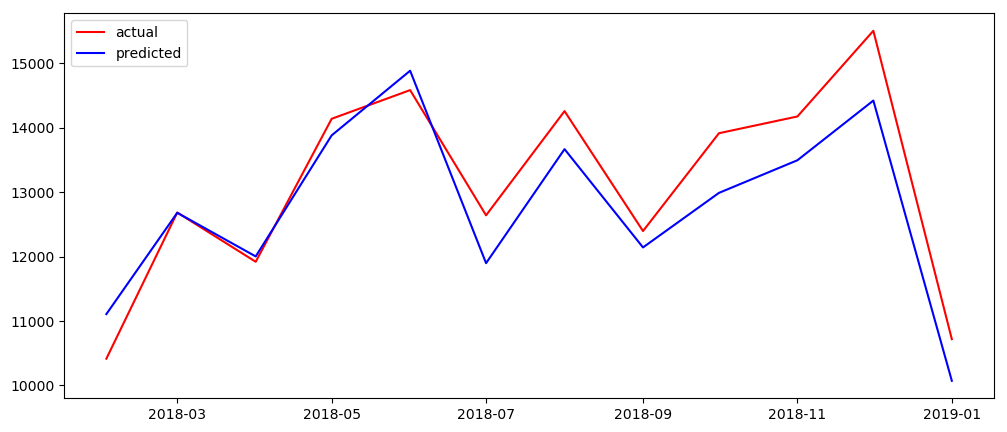

In [145]:
plt.figure(figsize=(12,5))
plt.plot(df[313:],'r',label='actual')
plt.plot(pd.DataFrame(true_predictions,index=df[313:].index,columns=df[313:].columns),'b',label='predicted')
plt.legend()
plt.show();

In [146]:
print("MAE:",mean_absolute_error(df[313:].values,true_predictions))
print("MSE:",mean_squared_error(df[313:].values,true_predictions))
print("RMSE:",np.sqrt(mean_squared_error(df[313:].values,true_predictions)))

MAE: 521.5201822916666
MSE: 376362.5342640877
RMSE: 613.4839315451446


### Forecast into the Unknown Future

In [151]:
test_predictions = []
first_eval_batch = train[-n_inputs:].values
current_batch = first_eval_batch.reshape((1,n_inputs,n_features))

for i in range(50):
    pred = model.predict(current_batch)[0]
    test_predictions.append(pred)
    current_batch = np.append(current_batch[:,1:,:],[[pred]],axis=1)

1/1 [==============================] - 0s 25ms/step


In [152]:
test_predictions = np.array(test_predictions)
test_predictions.shape

(50, 1)

In [153]:
test_predictions

array([[0.69029766],
       [0.8247324 ],
       [0.76681703],
       [0.9273901 ],
       [1.0131452 ],
       [0.75785255],
       [0.90914345],
       [0.7787528 ],
       [0.8511026 ],
       [0.89439094],
       [0.97358227],
       [0.6018433 ],
       [0.7373995 ],
       [0.8425673 ],
       [0.8058837 ],
       [0.9536344 ],
       [1.02789   ],
       [0.7930703 ],
       [0.93256915],
       [0.7991276 ],
       [0.8758723 ],
       [0.91379756],
       [0.9886254 ],
       [0.6465056 ],
       [0.7768476 ],
       [0.8613484 ],
       [0.8422327 ],
       [0.9795639 ],
       [1.0442704 ],
       [0.82461697],
       [0.95694065],
       [0.81973606],
       [0.9018466 ],
       [0.93347114],
       [1.0054168 ],
       [0.6904533 ],
       [0.81166875],
       [0.88114464],
       [0.877091  ],
       [1.0061848 ],
       [1.0621158 ],
       [0.85375965],
       [0.9824283 ],
       [0.8406829 ],
       [0.9291418 ],
       [0.95381993],
       [1.0239745 ],
       [0.730

In [154]:
true_predictions = scaler.inverse_transform(test_predictions.reshape(-1,1))
true_predictions

array([[11106.792 ],
       [12679.545 ],
       [12001.993 ],
       [13880.536 ],
       [14883.785 ],
       [11897.117 ],
       [13667.069 ],
       [12141.629 ],
       [12988.049 ],
       [13494.4795],
       [14420.938 ],
       [10071.965 ],
       [11657.837 ],
       [12888.195 ],
       [12459.034 ],
       [14187.568 ],
       [15056.284 ],
       [12309.13  ],
       [13941.126 ],
       [12379.993 ],
       [13277.831 ],
       [13721.519 ],
       [14596.929 ],
       [10594.469 ],
       [12119.34  ],
       [13107.915 ],
       [12884.28  ],
       [14490.919 ],
       [15247.919 ],
       [12678.194 ],
       [14226.248 ],
       [12621.093 ],
       [13581.704 ],
       [13951.68  ],
       [14793.37  ],
       [11108.613 ],
       [12526.713 ],
       [13339.511 ],
       [13292.088 ],
       [14802.356 ],
       [15456.692 ],
       [13019.134 ],
       [14524.429 ],
       [12866.15  ],
       [13901.03  ],
       [14189.74  ],
       [15010.478 ],
       [11577

In [160]:
df[313:]

,Sales
DATE,
2018-02-01,10415
2018-03-01,12683
2018-04-01,11919
2018-05-01,14138
2018-06-01,14583
2018-07-01,12640
2018-08-01,14257
2018-09-01,12396
2018-10-01,13914


In [165]:
timestep_range = pd.date_range('2018-02-01','2022-03-01',freq='MS')
timestep_range

DatetimeIndex(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01'],
              dtype='datetime64[ns]', freq='MS')

In [166]:
len(timestep_range)

50

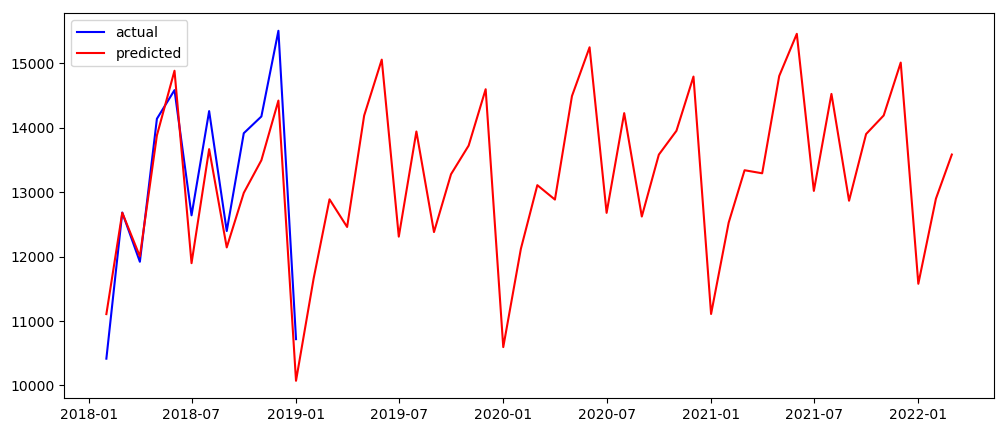

In [168]:
plt.figure(figsize=(12,5))
plt.plot(df[313:],'b',label='actual')
plt.plot(pd.DataFrame(true_predictions,index=timestep_range,columns=df[313:].columns),'r',label='predicted')
plt.legend()
plt.show();

In [169]:
model.save('alcohol_sales_forecaster.keras')

In [170]:
load_model('alcohol_sales_forecaster.keras').summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 150)               91200     
                                                                 
 dense_4 (Dense)             (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________
